In [22]:
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterGrid

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from skimage import segmentation, graph, exposure
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, disk, opening, closing

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import re
import json
import shutil
import glob
import multiprocessing
import logging

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Data Loading and Preparing

## Step 1: Load and calculate the target variable ("Average Whole CA1")

This automates the process of matching histological image files to corresponding data records. It begins by loading an Excel file containing data such as image names, IDs, treatments, and CA1 values, which are then preprocessed and standardized. Image names are standardized differently for matching and averaging purposes: for matching, the code strips out session markers and camera indicators, whereas for averaging, only session markers are removed. It then matches image files from a specified directory to the preprocessed data, calculates the average 'Whole CA1' value across different session markers, and stores the results. If any image files do not correspond to a record, they are moved to a separate 'unmatched' directory. Finally, the script can display each matched image alongside its relevant data, such as the image name, ID, individual, and average CA1 values.

In [23]:
def load_excel_data(filepath):
    df = pd.read_excel(filepath, header=1)
    df = df.iloc[:, [0, 1, 3, 14]].copy()
    df.columns = ['Image name', 'ID', 'Treatment', 'Whole CA1']
    df['Treatment'] = df['Treatment'].str.upper()
    df['Whole CA1'] = pd.to_numeric(df['Whole CA1'], errors='coerce').fillna(0)
    return df

def standardize_image_name_for_averaging(image_name):
    # Keep the "c1", "c2", etc. parts for the purpose of averaging
    return re.sub(r'_S\d+', '', image_name)

def standardize_image_name_for_matching(image_name):
    # Remove the "S#" part and the "c1", "c2", etc. parts for the purpose of matching
    return re.sub(r'(_S\d+)?(_c\d+)?$', '', image_name).split('20x')[0] + '20x'

def match_images_to_data(image_dir, df):
    df['Averaging Image Name'] = df['Image name'].apply(standardize_image_name_for_averaging)
    df['Matching Image Name'] = df['Image name'].apply(standardize_image_name_for_matching)

    # Compute the average 'Whole CA1' for each image name for averaging
    average_ca1 = df.groupby('Averaging Image Name')['Whole CA1'].mean().reset_index()
    average_ca1.columns = ['Averaging Image Name', 'Average Whole CA1']
    df = df.merge(average_ca1, on='Averaging Image Name', how='left')

    unmatched_images_dir = os.path.join(image_dir, 'unmatched')
    if not os.path.exists(unmatched_images_dir):
        os.makedirs(unmatched_images_dir)

    print("Starting to match images to data...")
    files_found = matches_found = 0
    image_records = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            files_found += 1
            standardized_filename_for_matching = standardize_image_name_for_matching(filename)
            matched_rows = df[df['Matching Image Name'] == standardized_filename_for_matching]
            print("Processed filename:", standardized_filename_for_matching)
            print("Number of matched rows:", len(matched_rows))

            if not matched_rows.empty:
                matches_found += 1
                # Aggregate the average 'Whole CA1' for all matched rows
                average_whole_ca1 = matched_rows['Average Whole CA1'].iloc[0]  # Assuming all matches have the same average
                image_records.append({
                    'Image name': filename,
                    'ID': matched_rows['ID'].iloc[0],  # Assuming all matches have the same ID
                    'Whole CA1': matched_rows['Whole CA1'].iloc[0],  # Take the 'Whole CA1' of the first matching row
                    'Average Whole CA1': average_whole_ca1
                })
            else:
                # Move unmatched files to the unmatched directory
                shutil.move(os.path.join(image_dir, filename), os.path.join(unmatched_images_dir, filename))
                print(f"Moved unmatched file {filename} to {unmatched_images_dir}")

    matched_df = pd.DataFrame(image_records)
    print("Shape of matched_df:", matched_df.shape)
    if not matched_df.empty:
        print(matched_df)

    print(f"Files processed: {files_found}, Matches found: {matches_found}")
    return matched_df

def display_matched_image(image_path, record):
    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"{record['Image name']}\nMatched Record: ID = {record['ID']}, Whole CA1 = {record['Whole CA1']}, Average Whole CA1 = {record['Average Whole CA1']:.2f}")
    plt.axis('off')
    plt.show()

# Paths
base_dir = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy'
excel_path = os.path.join(base_dir, 'Capstone_histology_data.xlsx')
images_path = os.path.join(base_dir, 'MouseNeuroImages\\original_images')

# Load the data and perform matching
data_df = load_excel_data(excel_path)
matched_df = match_images_to_data(images_path, data_df)
print(data_df.head())


Starting to match images to data...
Processed filename: 022218JK0_C_S2_20x
Number of matched rows: 1
Processed filename: 022218JK0_C_S2_20x
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20x
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20x
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20x
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20x
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20x
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20x
Number of matched rows: 1
Processed filename: 040318JK7_I_S1_20x
Number of matched rows: 1
Processed filename: 040318JK7_I_S1_20x
Number of matched rows: 1
Shape of matched_df: (10, 4)
                       Image name          ID  Whole CA1  Average Whole CA1
0   022218JK0_C_S2_20xZpro_c1.png   022218JK0          7                5.0
1   022218JK0_C_S2_20xZpro_c2.png   022218JK0          7                5.0
2   022218JK0_I_S1_20xZpro_c1.png   022218JK0        

C:\Users\David\anaconda3\envs\newenv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Step 2: Pair images to overlay

This cell pairs red and green stained photos of the same instance to create new overlay images necessary for counting the number of overlapping protein markers (Whole CA1)

In [24]:
def find_image_pairs(image_dir):
    """Identify pairs of images with 'c1' and 'c2' in their filenames sharing the same prefix."""
    files = os.listdir(image_dir)
    pairs = {}
    temp_dict = {}

    for file in files:
        if file.endswith('.png'):
            base_name = file.rsplit('_', 1)[0]
            suffix = file.split('_')[-1]

            if suffix in ['c1.png', 'c2.png']:
                if base_name not in temp_dict:
                    temp_dict[base_name] = {}
                temp_dict[base_name][suffix] = file

    for base_name, suffixes in temp_dict.items():
        if 'c1.png' in suffixes and 'c2.png' in suffixes:
            pairs[suffixes['c1.png']] = suffixes['c2.png']
            print("Pair found:", suffixes['c1.png'], "with", suffixes['c2.png'])

    return pairs

image_pairs = find_image_pairs(images_path)
print("Image pairs:", image_pairs)

Pair found: 022218JK0_C_S2_20xZpro_c1.png with 022218JK0_C_S2_20xZpro_c2.png
Pair found: 022218JK0_I_S1_20xZpro_c1.png with 022218JK0_I_S1_20xZpro_c2.png
Pair found: 040318JK12_I_S2_20xZpro_c1.png with 040318JK12_I_S2_20xZpro_c2.png
Pair found: 040318JK50_I_S2_20xZpro_c1.png with 040318JK50_I_S2_20xZpro_c2.png
Pair found: 040318JK7_I_S1_20xZpro_c1.png with 040318JK7_I_S1_20xZpro_c2.png
Image pairs: {'022218JK0_C_S2_20xZpro_c1.png': '022218JK0_C_S2_20xZpro_c2.png', '022218JK0_I_S1_20xZpro_c1.png': '022218JK0_I_S1_20xZpro_c2.png', '040318JK12_I_S2_20xZpro_c1.png': '040318JK12_I_S2_20xZpro_c2.png', '040318JK50_I_S2_20xZpro_c1.png': '040318JK50_I_S2_20xZpro_c2.png', '040318JK7_I_S1_20xZpro_c1.png': '040318JK7_I_S1_20xZpro_c2.png'}


## Step 3: Overlay Images

This cell passes the dictionary of paired images from the cells above. The code outputs dataframe information, loops through the image pairs, and calls a function to overlay the images. The images' corresponding "Average Whole CA1" values are then averaged together and formed into a dataframe for the Whole Average CA1 count of the overlayed image.

Overlaying the images utilized the Python Imaging Library (PIL). This allows for an Image object to be opened/closed/resized, converted in its color scale, and converted between an Image object and an array-like object. The overlaying method first converts both images from the Original_images folder into RGBA. The method then ensures that image pairs match in size then converts both images into array-like objects. The weighted sum of the arrays is taken, defining the pixel value to be added for each image with the alpha and 1-alpha parameters. We want both images to have equal pixel weight, so alpha = 0.5. 

The overlayed images are displayed using matplotlib and saved to the new overlayed images directory using the shutil package. The resulting dataframe of the Average Whole CA1 count on the overlayed image is also output for easy rerference to the ground truth in the model evaluation phase.


Overlaying image pairs...
Shape of matched_df: (10, 4)
Columns in matched_df: Index(['Image name', 'ID', 'Whole CA1', 'Average Whole CA1'], dtype='object')
Image names in dataset: ['022218JK0_C_S2_20xZpro_c1.png', '022218JK0_C_S2_20xZpro_c2.png', '022218JK0_I_S1_20xZpro_c1.png', '022218JK0_I_S1_20xZpro_c2.png', '040318JK12_I_S2_20xZpro_c1.png', '040318JK12_I_S2_20xZpro_c2.png', '040318JK50_I_S2_20xZpro_c1.png', '040318JK50_I_S2_20xZpro_c2.png', '040318JK7_I_S1_20xZpro_c1.png', '040318JK7_I_S1_20xZpro_c2.png']
Current pair 1: 022218JK0_C_S2_20xZpro_c1.png with 022218JK0_C_S2_20xZpro_c2.png


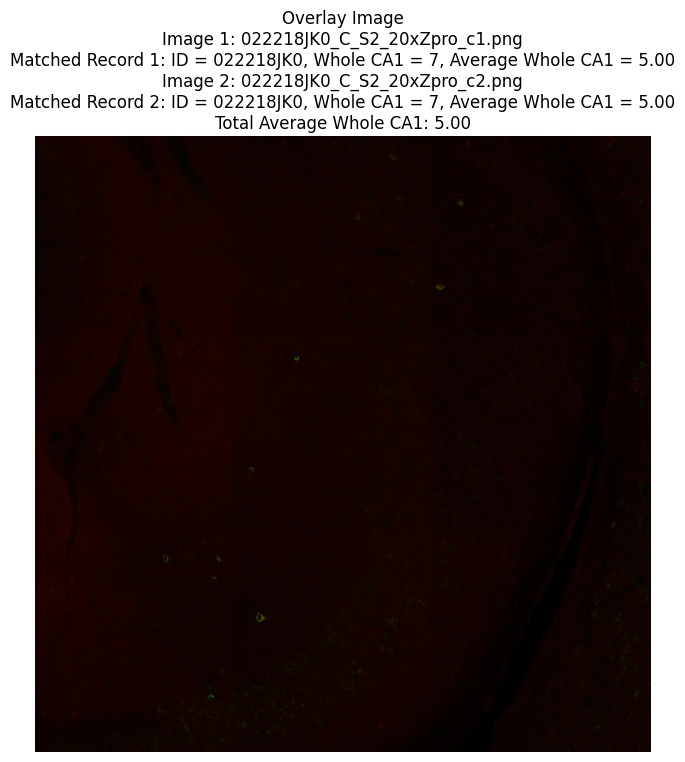

Processed pair 1/5
Current pair 2: 022218JK0_I_S1_20xZpro_c1.png with 022218JK0_I_S1_20xZpro_c2.png


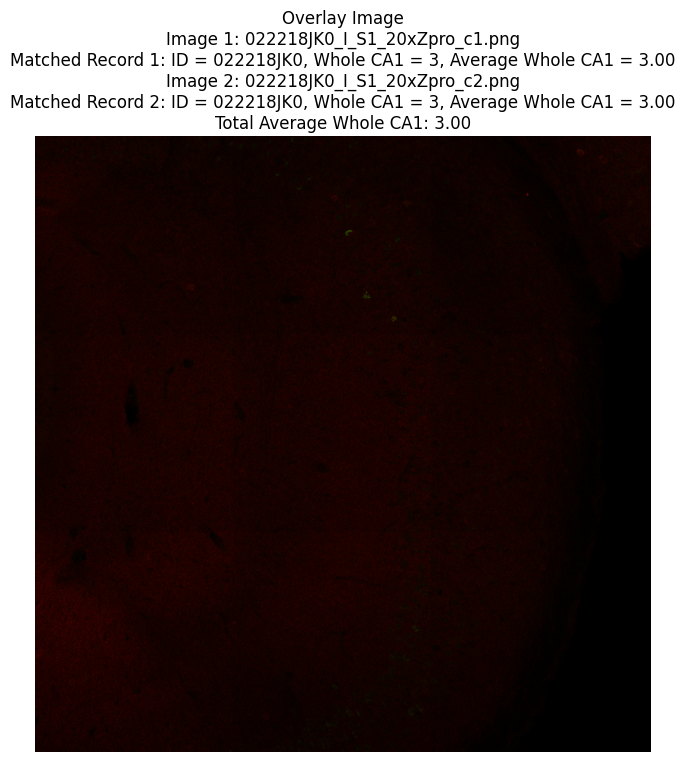

Processed pair 2/5
Current pair 3: 040318JK12_I_S2_20xZpro_c1.png with 040318JK12_I_S2_20xZpro_c2.png


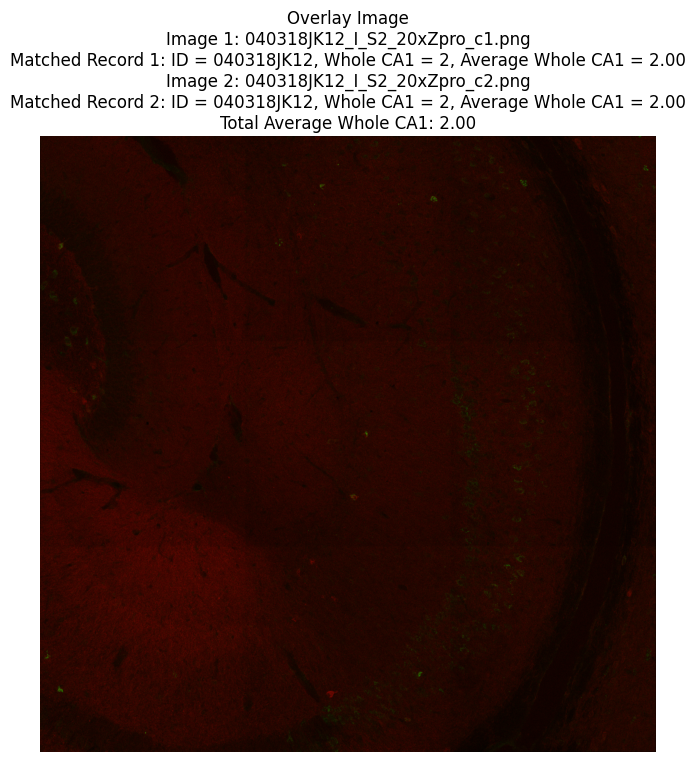

Processed pair 3/5
Current pair 4: 040318JK50_I_S2_20xZpro_c1.png with 040318JK50_I_S2_20xZpro_c2.png


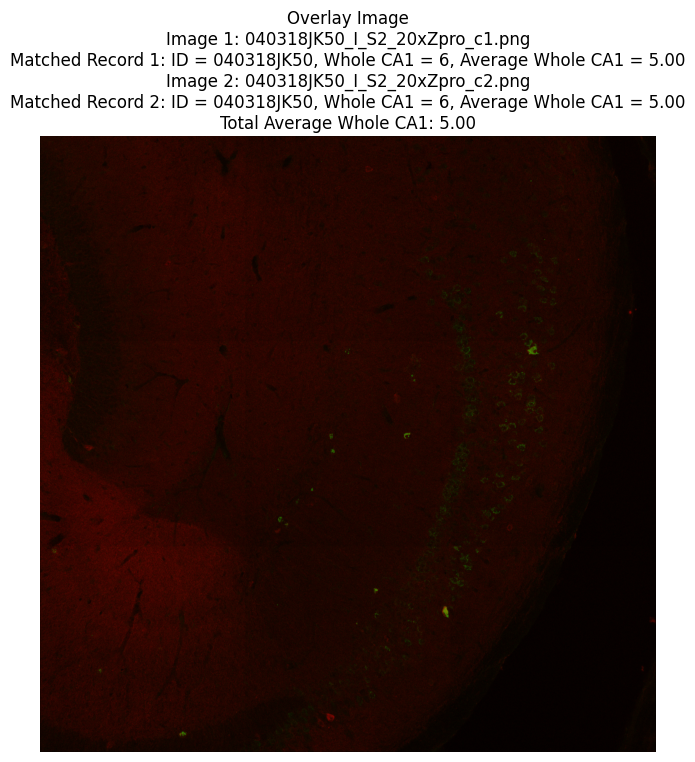

Processed pair 4/5
Current pair 5: 040318JK7_I_S1_20xZpro_c1.png with 040318JK7_I_S1_20xZpro_c2.png


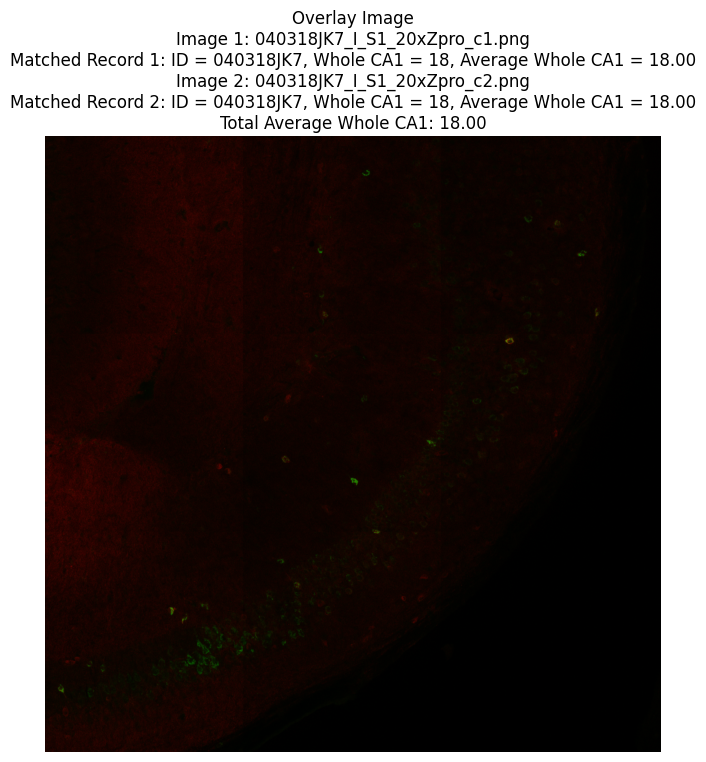

Processed pair 5/5
                       Overlay Image Name  Average Whole CA1
0   022218JK0_C_S2_20xZpro_c1_overlay.png                5.0
1   022218JK0_I_S1_20xZpro_c1_overlay.png                3.0
2  040318JK12_I_S2_20xZpro_c1_overlay.png                2.0
3  040318JK50_I_S2_20xZpro_c1_overlay.png                5.0
4   040318JK7_I_S1_20xZpro_c1_overlay.png               18.0


In [25]:
def overlay_images(img1_path, img2_path, output_path, alpha=0.5):
    """Overlay two images with specified alpha for each."""
    img1 = Image.open(img1_path).convert("RGBA")
    img2 = Image.open(img2_path).convert("RGBA")

    if img1.size != img2.size:
        img1 = img1.resize(img2.size)
        
    img1_np = np.array(img1)
    img2_np = np.array(img2)

    overlay = cv2.addWeighted(img1_np, alpha, img2_np, 1 - alpha, 0)
    overlay_img = Image.fromarray(overlay)

    overlay_img.save(output_path)

    return overlay_img

def display_overlayed_image(overlay_img, record1, record2):
    overlay = overlay_img  # Use the provided overlay image

    # Calculate the total Average Whole CA1 for the overlayed image
    total_average_ca1 = (record1['Average Whole CA1'] + record2['Average Whole CA1'])/2

    plt.figure(figsize=(10, 8)) 
    plt.imshow(overlay)
    plt.title(f"Overlay Image\n"
              f"Image 1: {record1['Image name']}\n"
              f"Matched Record 1: ID = {record1['ID']}, Whole CA1 = {record1['Whole CA1']}, Average Whole CA1 = {record1['Average Whole CA1']:.2f}\n"
              f"Image 2: {record2['Image name']}\n"
              f"Matched Record 2: ID = {record2['ID']}, Whole CA1 = {record2['Whole CA1']}, Average Whole CA1 = {record2['Average Whole CA1']:.2f}\n"
              f"Total Average Whole CA1: {total_average_ca1:.2f}")
    plt.axis('off')
    plt.show()

def overlay_image_pairs(image_pairs, input_dir, output_dir, matched_df):
    overlay_data = []
    
    total_pairs = len(image_pairs)
    print("Overlaying image pairs...")
    print("Shape of matched_df:", matched_df.shape)
    print("Columns in matched_df:", matched_df.columns)
    print("Image names in dataset:", matched_df['Image name'].tolist())

    for i, (img1_name, img2_name) in enumerate(image_pairs.items(), start=1):
        print(f"Current pair {i}: {img1_name} with {img2_name}")
        
        if img1_name not in matched_df['Image name'].values or img2_name not in matched_df['Image name'].values:
            print(f"No match found for {img1_name} or {img2_name} in matched_df")
            continue

        img1_record = matched_df[matched_df['Image name'] == img1_name].iloc[0]
        img2_record = matched_df[matched_df['Image name'] == img2_name].iloc[0]

        average_whole_ca1 = (img1_record['Average Whole CA1'] + img2_record['Average Whole CA1'])/2

        img1_path = os.path.join(input_dir, img1_name)
        img2_path = os.path.join(input_dir, img2_name)
        output_path = os.path.join(output_dir, f"{img1_name[:-4]}_overlay.png")

        overlay_img = overlay_images(img1_path, img2_path, output_path, alpha=0.5)
        display_overlayed_image(overlay_img, img1_record, img2_record)
        
        overlay_data.append({
            'Overlay Image Name': os.path.basename(output_path),
            'Average Whole CA1': average_whole_ca1
        })

        print(f"Processed pair {i}/{total_pairs}")

    overlay_df = pd.DataFrame(overlay_data)
    return overlay_df
       
overlay_image_dir = os.path.join(base_dir, 'MouseNeuroImages\\overlay_images')

os.makedirs(overlay_image_dir, exist_ok=True)
overlay_df = overlay_image_pairs(image_pairs, images_path, overlay_image_dir, matched_df)
print(overlay_df)

# Manual Filtering Model

## Step 1: Define Filtering Functions

From initial visual inspection, the instances of interest are brighter and of varying sizes than the pixels in the rest of the image. Using the OpenCV library, the overlayed images are first converted to grayscale. The 2 channels now represent red and green channels, and the split function assigns the decoded grayscale image into its "red" and "green" channels.

The threshold function evaluates these 2 channels on their user-assigned threshold values using a bitwise_and conjunction of the two channel arrays to binarize the images. The computer vision library allows this filter to be made that mimicks the standout of bright spots when counting protein markers.

Filtering by size required the use of adaptive threholding, which is meant to adjust the threshold of a pixel based on a small region around it. This becomes useful for images with varying illumination. The adaptive threshold takes in a grey scale image, a Gaussian-weghted sum of the neighborhood values minus the constant, a maximum value to set the threshold-exceeding pixels to during binarization, and the area of the pizel neighborhood used in threshold calculation. The filtering by size includes contour detection, where the findContours function processes the binarized image returned from the adaptive thresholding. findContours specifies a retrieval mode and a contour approximation method that uses horizontal, vertical, and diagonal endpoints to remove redundant points in the tracing. 

The result of the adaptive thresholding, contour detection, and contour area functions are the isolation of these contours within a user-specified area range. 

## Step 2: Preparing Data

The data is prepared with the creation of the dataframe to hold the expected count of protein markers for each filtered image (Average Whole CA1). One or both of the filter(s) (color intensity and size) can be applied to return the filtered image. The cell below only applies the color filter.

The process_image_with_parameters function takes in the path of the image and the thresholds for binarizing the red and green channels as arguments. The returned image is converted into a single channel grey scale image and flattened froma 2D array, representing pixel layout, to a 1 dimensional vector necessary for the RandomForestRegressor. 

## Step 3: Train RandomForestRegressor

Sci-kit learn's parameter_grid function generates a cartesian product of the parameters to create a list of all possible parameter combinations. Different values for thresholds in the red and green channels, as well as values for the number of trees in the RandomForest model and the depth of each tree are provided to the grid search.

The images are split into 33% of the filtered overlayed images being reserved for model testing, and the remaining images train RandomForestRegressor. When the filtered image was flattened into a 1 dimensional vector of a binarized image, the feature vector that the RandomForestRegressor learned from was the feature vectors with a greater number of positive binary instances were associated with a greater number of the Average Whole CA1 count from its associated record in the ground truth dataframe. The parameter grid accepts the tree depth and number of esitmators for the RandomForestRegressor for model hyperparamter tuning.

The metric for the best model is the mean absolute error (MAE) of instances detected. Since the regression function includes a call to the prepare_data method, the ground truth dataframe of the filtered image is formed and the MAE is calculated as the difference between the test values and the predicted instances. The model with the combination of parameters that result in the lowest MAE is used for predictions. 

In [26]:
def filter_instances_by_color(image, red_threshold, green_threshold):
    """Apply color thresholds and return filtered image."""
    _, green_channel, red_channel = cv2.split(image)
    _, red_binary = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    _, green_binary = cv2.threshold(green_channel, green_threshold, 255, cv2.THRESH_BINARY)
    red_and_green = cv2.bitwise_and(red_binary, green_binary)
    filtered_image = cv2.bitwise_and(image, image, mask=red_and_green)
    return filtered_image

def filter_instances_by_size(image, min_area, max_area):
    """Apply size filtering to binary image and return filtered contours."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
    
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]
    
    return filtered_contours

def process_image_with_parameters(image_path, red_threshold, green_threshold):
    """Process an image with given red and green thresholds."""
    image = cv2.imread(image_path)
    if image is None:
        logging.warning(f"Image at {image_path} could not be loaded.")
        return None
    
    image = cv2.resize(image, (256, 256))
    filtered_image = filter_instances_by_color(image, red_threshold, green_threshold)
    return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY).flatten()

def prepare_dataset(image_dir, overlay_df, red_threshold, green_threshold):
    X, y = [], []
    filenames = []
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Name'])
        features = process_image_with_parameters(image_path, red_threshold, green_threshold)
        if features is not None:
            X.append(features)
            y.append(row['Average Whole CA1'])
            filenames.append(row['Overlay Image Name'])
    return np.array(X), np.array(y), filenames
    
def perform_regression(image_dir, overlay_df, param_grid):
    """Perform regression analysis with grid search."""
    best_model = None
    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        logging.info(f"Testing parameters: {params}")
        X, y, _ = prepare_dataset(image_dir, overlay_df, params['red_threshold'], params['green_threshold'])

        if len(X) == 0:
            logging.warning("No data to fit the model.")
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=478)
        model = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=478)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)

        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
            logging.info(f"New best model with parameters: {best_params} and score: {best_score}")

    logging.info(f"Best Parameters: {best_params}")
    logging.info(f"Best Score: {best_score}")

    return best_model, best_params

param_grid = {
    'red_threshold': [55, 60],
    'green_threshold': [50, 55, 60],
    'n_estimators': [50, 100],
    'max_depth': [None]
}

best_model, best_params = perform_regression(overlay_image_dir, overlay_df, param_grid)


## Step 4: Test the model on unseen data

This step involves appending a new column to the filtered image data frame for the protein marker overlap count predictions. In the predict_all_images function, the call to process_images_with_parameters begins the chain of method calls to the filtering methods and returns a binarized feature vector of overlapped pixels that both exceeded the threshold. 

The best model obtained from the grid search is used and the predictions are added to the new column. The call to the predict_all_images function takes in the non-filtered overlayed images, the dataframe with the ground truth information, and the threshold values of pixel brightness to appropriately filter the overlayed images.

These filtered images are output, where it becomes evident that the instances being counted are mostly not visible aside from a few images. This inspires the use of size filtering as another layer, to ensure the instances being counted are ones that the researchers agree on.

                       Overlay Image Name  Average Whole CA1  \
0   022218JK0_C_S2_20xZpro_c1_overlay.png                5.0   
1   022218JK0_I_S1_20xZpro_c1_overlay.png                3.0   
2  040318JK12_I_S2_20xZpro_c1_overlay.png                2.0   
3  040318JK50_I_S2_20xZpro_c1_overlay.png                5.0   
4   040318JK7_I_S1_20xZpro_c1_overlay.png               18.0   

   Predicted Total Average Whole CA1  
0                               5.00  
1                               5.00  
2                               4.62  
3                               5.20  
4                              10.64  


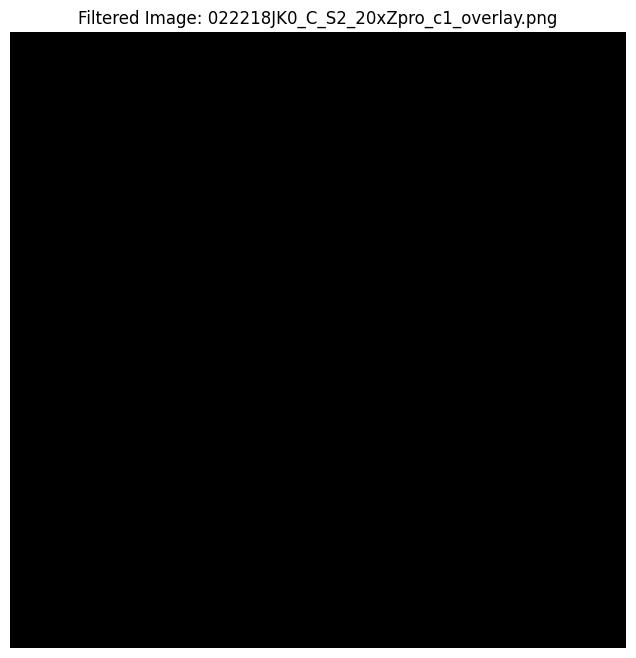

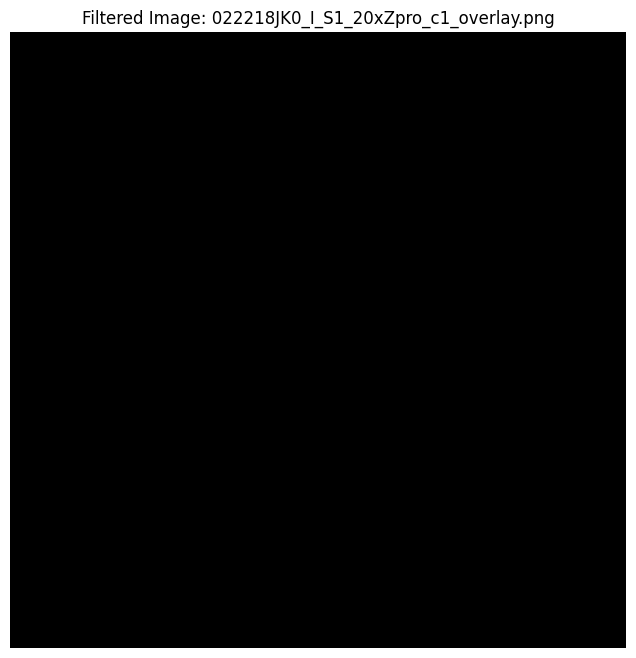

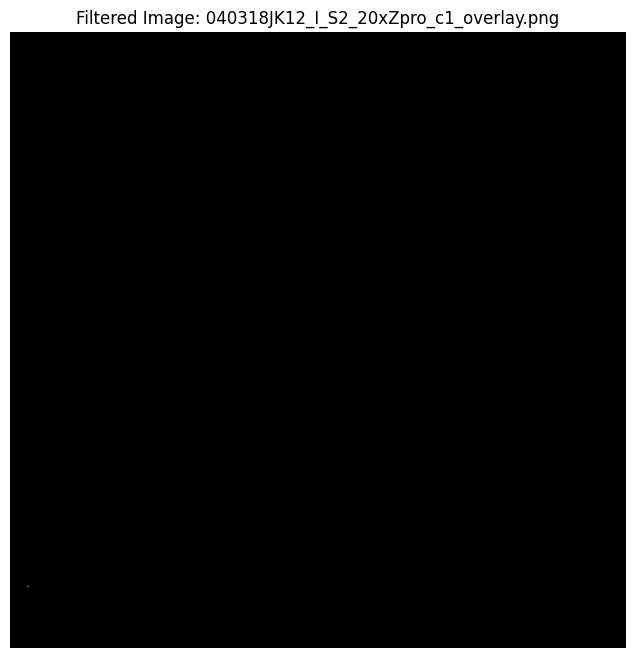

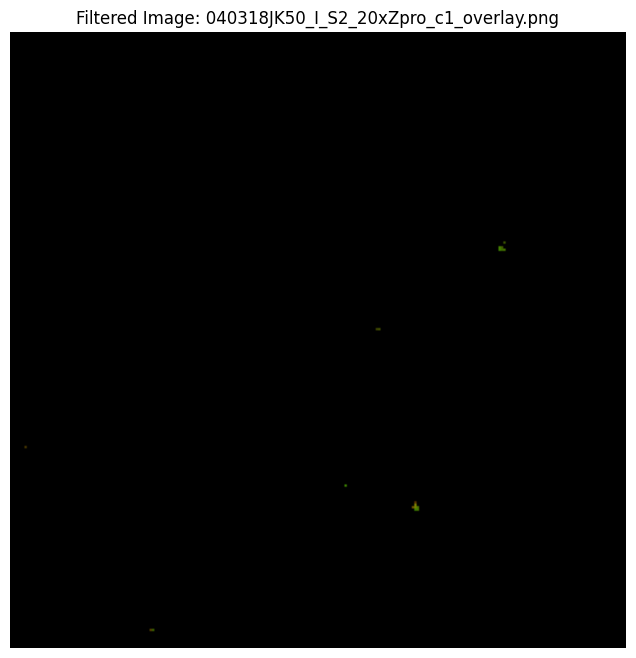

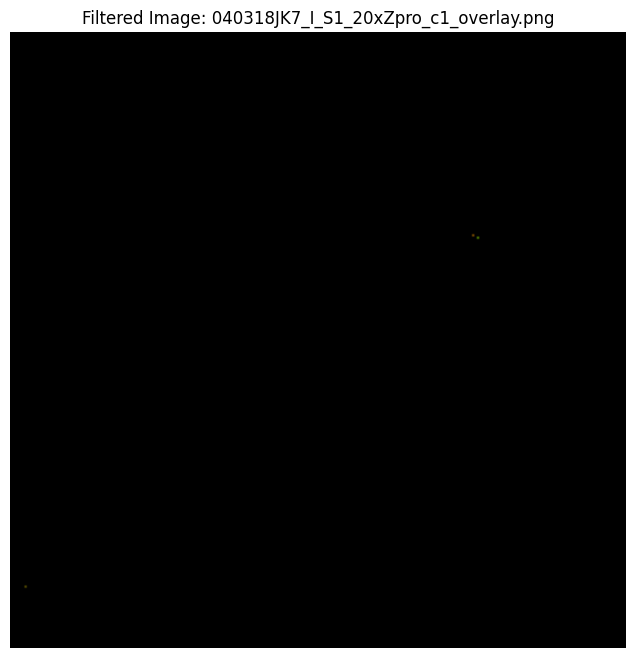

In [27]:
def predict_all_images(image_dir, overlay_df, best_model, red_threshold, green_threshold):
    overlay_df['Predicted Total Average Whole CA1'] = np.nan
    
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Name'])
        features = process_image_with_parameters(image_path, red_threshold, green_threshold)
        if features is not None:
            predicted_instances = best_model.predict([features])[0]
            overlay_df.at[index, 'Predicted Total Average Whole CA1'] = predicted_instances
            logging.info(f"Image: {row['Overlay Image Name']}, Predicted Total Average Whole CA1: {predicted_instances}")

    return overlay_df

overlay_df_with_predictions = predict_all_images(
    overlay_image_dir,
    overlay_df,
    best_model,
    best_params['red_threshold'],
    best_params['green_threshold']
)

overlay_df_with_predictions['Overlay Image Name'] = overlay_df_with_predictions['Overlay Image Name'].apply(lambda x: os.path.basename(x))

print(overlay_df_with_predictions)

def visualize_filtered_images(image_dir, overlay_df, red_threshold, green_threshold):
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Name'])
        image = cv2.imread(image_path)
        if image is None:
            logging.warning(f"Image at {image_path} could not be loaded.")
            continue
            
        image = cv2.resize(image, (256, 256))
        
        filtered_image = filter_instances_by_color(image, red_threshold, green_threshold)
        
        # Display the filtered image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Filtered Image: {row['Overlay Image Name']}")
        plt.axis('off')
        plt.show()
        
visualize_filtered_images(overlay_image_dir, overlay_df, best_params['red_threshold'], best_params['green_threshold'])

## Step 5: Visualize Prediction Accuracy

This is a straightforward visualization of the differences between the predicted and the actual counts of protein markers in the overlayed images. The distance of points from the red dashed line represents the magnitude of the mean absolute error between true and predicted values for an image.

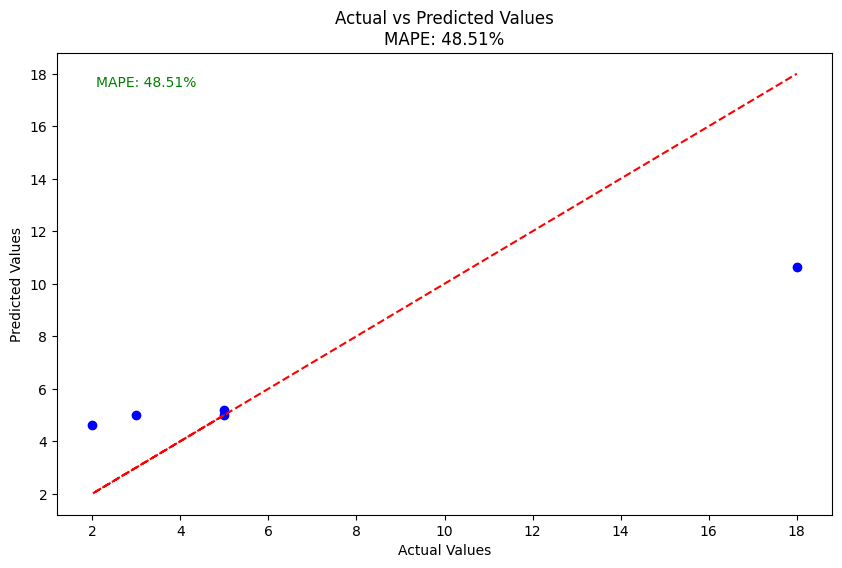

In [28]:
def visualize_predictions(actual_values, predicted_values):
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, color='blue')
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values\nMAPE: {mape:.2f}%')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    plt.text(0.05, 0.95, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, va='top', ha='left', color='green')
    
    plt.show()


# Extract actual and predicted values from overlay_df_with_predictions
actual_values = overlay_df_with_predictions['Average Whole CA1']
predicted_values = overlay_df_with_predictions['Predicted Total Average Whole CA1']

# Visualize the predictions
visualize_predictions(actual_values, predicted_values)

# Image Segmentation

## Step 1: Transform original overlayed images to augment and enhance the dataset

Developing a well-functioning neural network involves training the model on a sufficiently sized and varying dataset. Considering that only 5 overlayed images exist, this code cell uses the ImageDataGenerator from the Keras library to apply geometric transformation, axis flipping, rotations, height and width shifts, brightness adjustment, and newly introduced pixel filling to each original image.

After creating a new directory for the augmented dataset, the code cell fills the folder with the original overlayed images and its corressponding transformed image. This doubles the number of images for training and testing to 10 and adds variability for the model to learn from. The dataframe generated for this augmented data set uses the Whole Averge CA1 counts of the original overlayed images for the augmented ones.

In [29]:
original_overlay_image_dir = os.path.join(base_dir, 'MouseNeuroImages\\overlay_images')
augmented_overlay_image_dir = os.path.join(base_dir, 'MouseNeuroImages\\augmented_overlay_images')

os.makedirs(original_overlay_image_dir, exist_ok=True)
os.makedirs(augmented_overlay_image_dir, exist_ok=True)

data_list = []

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2]
)

for index, row in overlay_df.iterrows():
    filename = os.path.basename(row['Overlay Image Name'])
    file_extension = os.path.splitext(filename)[1]
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        original_image_path = os.path.join(original_overlay_image_dir, filename)
        shutil.copy2(original_image_path, augmented_overlay_image_dir)
        data_list.append({
            'Image Name': filename,
            'Average Whole CA1': row['Average Whole CA1']
        })

        image = load_img(original_image_path)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        for x, val in zip(datagen.flow(image, batch_size=1), range(1)):
            img = Image.fromarray((x[0] * 255).astype(np.uint8))
            augmented_filename = filename[:-len(file_extension)] + "_aug" + file_extension
            augmented_image_path = os.path.join(augmented_overlay_image_dir, augmented_filename)
            img.save(augmented_image_path)
            data_list.append({
                'Image Name': augmented_filename,
                'Average Whole CA1': row['Average Whole CA1']
            })
            
augmented_overlay_df = pd.DataFrame(data_list)

## Step 2: Split and organize the images and dataframes

This code cell splits the available images and the dataframe for the augmented images into training, testing, and validation sets. These splits are sent to their respective directories, as well as a dataframe of their corresponding records. Following this, the dimensions of the first image are returned as supplemental information.

In [30]:
augmented_overlay_image_dir = os.path.join(base_dir, 'MouseNeuroImages\\augmented_overlay_images')

train_df, test_val_df = train_test_split(augmented_overlay_df, test_size=0.3, random_state=500)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=500)

train_dir = os.path.join(augmented_overlay_image_dir, 'train')
val_dir = os.path.join(augmented_overlay_image_dir, 'validation')
test_dir = os.path.join(augmented_overlay_image_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

def copy_images_to_directory(df, destination_dir):
    for _, row in df.iterrows():
        filename = row['Image Name']
        source_path = os.path.join(augmented_overlay_image_dir, filename)
        destination_path = os.path.join(destination_dir, filename)
        shutil.copy2(source_path, destination_path)

copy_images_to_directory(train_df, train_dir)
copy_images_to_directory(val_df, val_dir)
copy_images_to_directory(test_df, test_dir)


## Step 3: Ensure the proper environment setup for training a deep neural network

A convolutional neural network (CNN) is a type of neural network best suited for classification and computer vision tasks, such as identifying biomarkers in medical imaging.

CNNs enable scalibility for otherwise tedious tasks of a person classifying images. This scalbility comes at the cost of computational demand, requiring graphical processing units to train the models.

## Steps to ensure hardware compatability:

Checking for the type of GPU available on the machine:

Tensorflow run with GPU support requires a compatible GPU, such as CUDA-compatible NVIDIA GPU

Windows: wmic path win32_VideoController get name

Linux: lspci | grep -i nvidia

If no CUDA-compatible GPU is available, the Intel Math Kernel Library for Deep Neural Networks can optimize performance on Intel CPUs

pip install intel-tensorflow --user


## CNNs Continued:

The three main layers in a CNN are the convolutional layer(s), the pooling layer, and the fully-connected layer. The earlier layers of the CNN focus on simple colors and edges, while the subsequent layers increase in complexity to identify shapes of the object until the object is finally identified.

The majority of the computation in a CNN occurs in the convolution layer, which consists of input data, a filter, and a feature map. The input data (an image) is a 3D matrix of pixels. The kernel, a 3x3 matrix that determines the size of the image region being filtered, acts as a filter for object detection. As the kernel (filter) sweeps across the image, a dot product is computed between the input image and the filter, sending the results to an output array. The final output is referred to as a feature map.

## Step 4: Load images and corresponding masks

CVAT is a web tool designed to help label images and videos for computer vision tasks. For this application, CVAT was used to outline the overalapping proteins and creating ground truth masks. These ground truth annotations were used to train the image segmentation models to make predicted masks.

The workflow here loads the CVAT annotations, then organizes the augmented dataset of overlayed images into training, validation, and test sets. The organization and visualization of each image and its corresponding mask ensures that the model is being trained on images with their accurately corresponding masks.

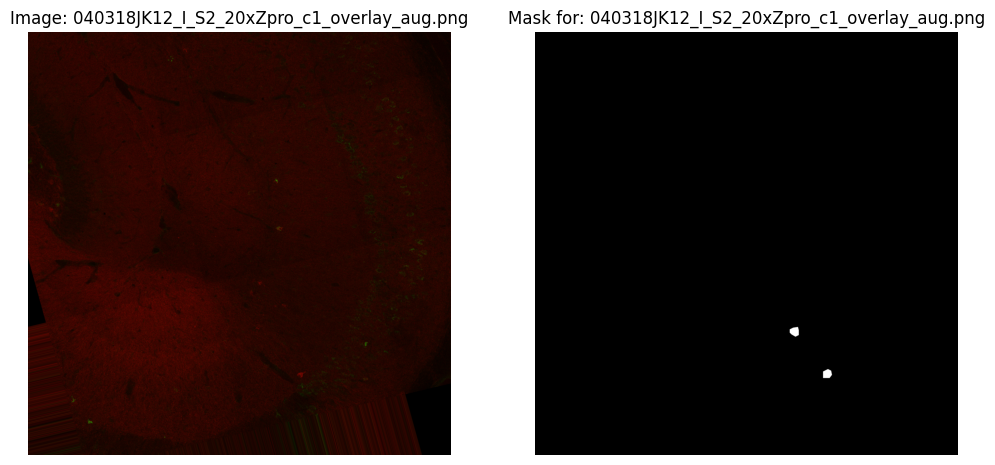

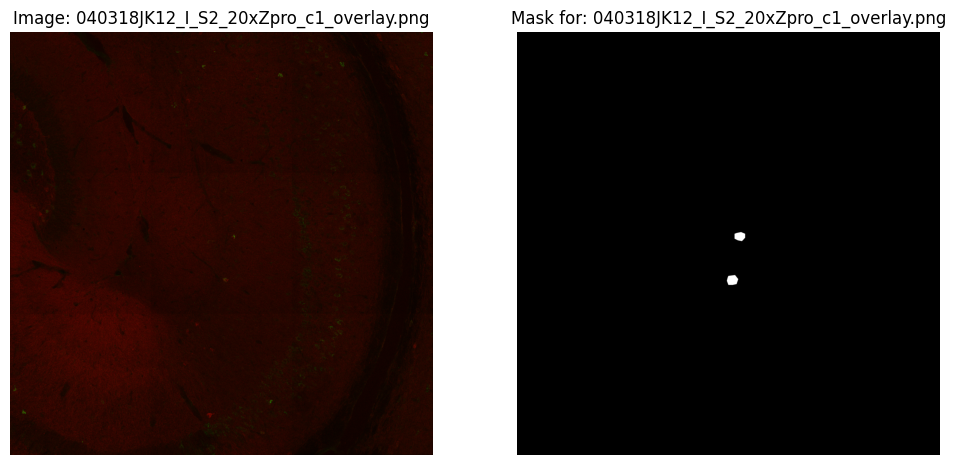

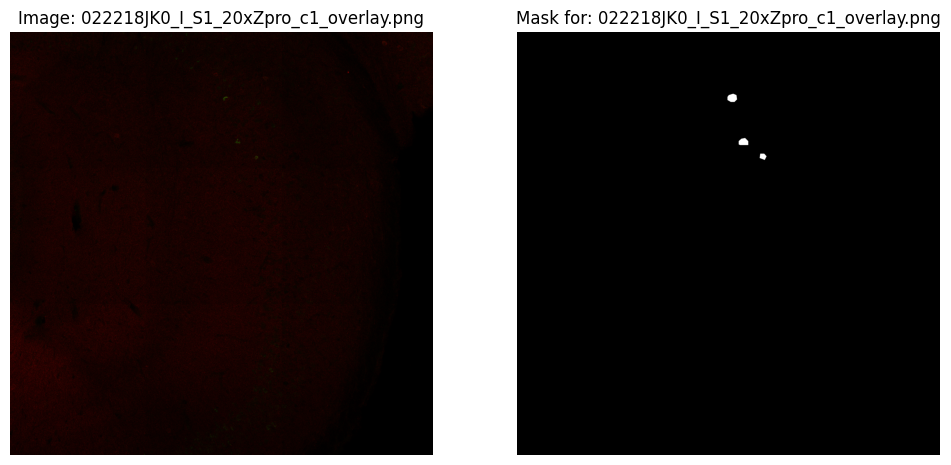

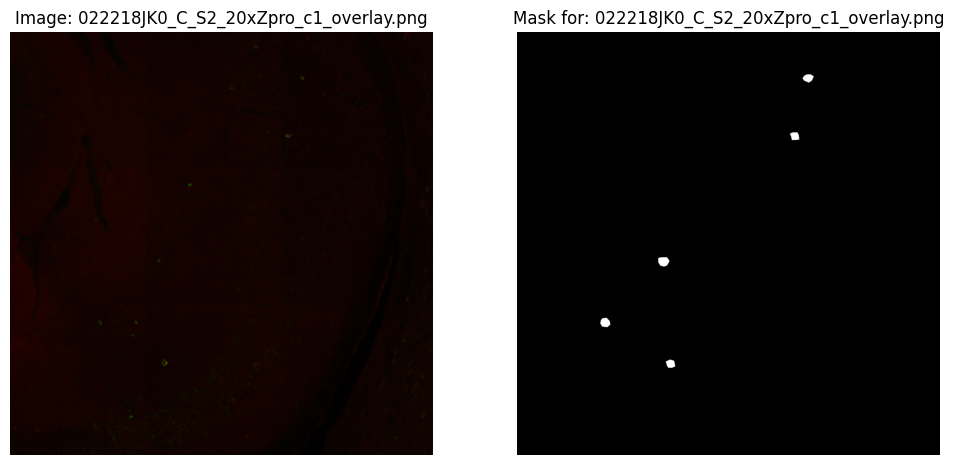

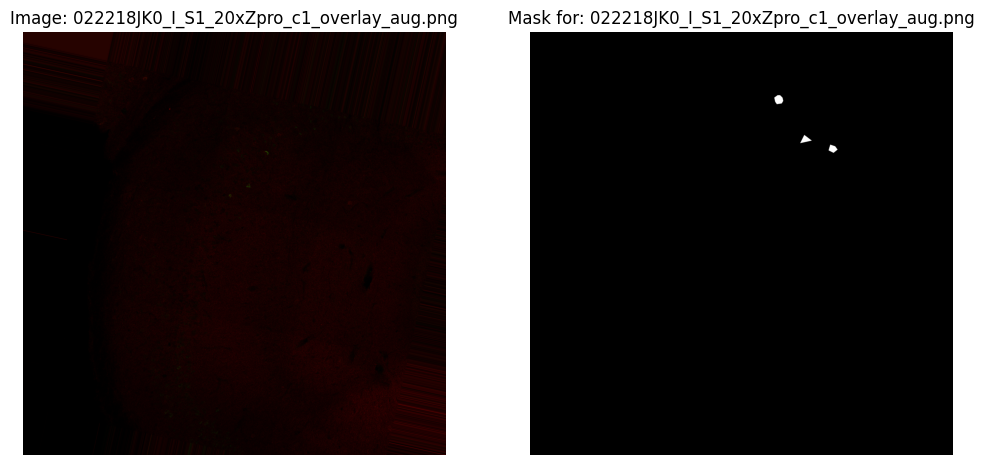

In [31]:
annotation_path = os.path.join(base_dir, 'annotations\\instances_default.json')
with open(annotation_path, 'r') as f:
    annotations = json.load(f)

def create_mask_from_annotations(annotations_list, image_info, image_size):
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)

    for annotation in annotations_list:
        if annotation['image_id'] == image_info['id']:
            segmentation = annotation['segmentation'][0]
            polygon = np.array(segmentation).reshape((-1, 2))
            cv2.fillPoly(mask, [polygon.astype(np.int32)], color=255)

    return mask

def copy_images_and_masks_to_directory(df, destination_dir, source_dir, annotations):
    for index, row in df.iterrows():
        filename = row['Image Name']
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)
        shutil.copy2(source_path, destination_path)

        image_info = next((item for item in annotations['images'] if item['file_name'] == filename), None)
        if image_info:
            image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_info['id']]
            image_size = (image_info['width'], image_info['height'])
            mask = create_mask_from_annotations(image_annotations, image_info, image_size)
            mask_filename = filename.replace('.png', '_mask.png')
            mask_path = os.path.join(destination_dir, mask_filename)
            colored_mask = cv2.merge([mask, mask, mask])
            cv2.imwrite(mask_path, colored_mask)

            if np.max(mask) == 0:
                print(f"The mask for image_id {image_info['id']} was all zeros after creation.")
            if not os.path.exists(mask_path):
                print(f"Mask file {mask_path} not found after attempted save.")

def display_images_and_annotations(image_dir, annotations, df):
    for index, row in df.iterrows():
        filename = row['Image Name']
        image_path = os.path.join(image_dir, filename)
        if not os.path.exists(image_path):
            continue

        image_info = next((item for item in annotations['images'] if item['file_name'] == filename), None)
        if not image_info:
            continue

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_info['id']]
        mask = create_mask_from_annotations(image_annotations, image_info, (image_info['width'], image_info['height']))

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        ax[0].imshow(image)
        ax[0].set_title(f"Image: {filename}")
        ax[0].axis('off')

        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title(f"Mask for: {filename}")
        ax[1].axis('off')

        plt.show()

train_df, test_val_df = train_test_split(augmented_overlay_df, test_size=0.3, random_state=100)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=478)

copy_images_and_masks_to_directory(train_df, train_dir, augmented_overlay_image_dir, annotations)
copy_images_and_masks_to_directory(val_df, val_dir, augmented_overlay_image_dir, annotations)
copy_images_and_masks_to_directory(test_df, test_dir, augmented_overlay_image_dir, annotations)

display_images_and_annotations(train_dir, annotations, train_df.head(5)) 


## Step 5: Train UNET model

### Step 5.1: Load the dataset

This code checks each image for its existence in its appropriate directory, reads the image file, convert its color space from BGR to RGB (as OpenCV loads images in BGR by default), resize it to a uniform size (256x256 pixels), and normalize its pixel values to the range (0,1). Following this, masks that represent the overlapping proteins are created from the annotations and are processed to match the image size and normalization.

The images and masks are both stored in arrays, with the filenames stored as a list for traceability in the visualization.

In [32]:
def load_dataset(directory, annotations, df):
    images = []
    masks = []
    filenames = [] 
    for index, row in df.iterrows():
        filename = row['Image Name']
        image_path = os.path.join(directory, filename)
        if not os.path.exists(image_path):
            continue

        filenames.append(filename)

        image_info = next((item for item in annotations['images'] if item['file_name'] == filename), None)
        if not image_info:
            continue

        # Read the image and preprocess
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = image / 255.0 
        images.append(image)

        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_info['id']]
        mask = create_mask_from_annotations(image_annotations, image_info, (image_info['width'], image_info['height']))
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1)
        masks.append(mask)

    return np.array(images), np.array(masks), filenames

train_images, train_masks, train_filenames = load_dataset(train_dir, annotations, train_df)
val_images, val_masks, val_filenames = load_dataset(val_dir, annotations, val_df)
test_images, test_masks, test_filenames = load_dataset(test_dir, annotations, test_df)

### Step 5.2: Defining a UNET model:

A U-Net model is a type of convolutional neural network designed specifically for semantic segmentation tasks, where the goal is to classify each pixel of an image as part of a particular object. The architecture is named for its U-shaped structure, which includes a contracting path to capture context and an expansive path that enables precise localization.
The U-Net below starts with a contracting path that reduces the spatial dimensions through convolutions and max pooling, using 32 and 64 filters with a kernel size of (3, 3) and relu activation. To mitigate overfitting, dropout is applied after convolutions with a rate of 0.1 or 0.2. The bottom of the U, or bottleneck, uses 128 filters to process the most compressed representation of the input. Then, in the expansive path, transposed convolutions are used for upsampling followed by concatenation with the corresponding layers from the contracting path, providing the network with features from multiple resolutions. The final layer outputs the segmentation map through a (1, 1) convolution with a sigmoid activation.

For trainingthe a custom loss function combesng Dice loss with Binary Crossentropy (BCE), leveraging the strengths of both: Dice loss is well-suited for imbalanced datasets, common in segmentation tasks, while BCE provides a stable training process. The model uses the Adam optimizer, batch size of 10, and is trained for 20 epochges.


In [33]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Contracting Path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1], axis=3)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

model = unet_model()
model.compile(optimizer=Adam(), loss=combined_dice_bce_loss, metrics=['accuracy', dice_coefficient])
model.fit(train_images, train_masks, batch_size=5, epochs=5, validation_data=(val_images, val_masks))

test_loss, test_accuracy, test_dice = model.evaluate(test_images, test_masks)
print(f"Test accuracy: {test_accuracy:.4f}, Dice coefficient: {test_dice:.4f}")

model.save(os.path.join(base_dir, 'unet_model.keras'))

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7016 - dice_coefficient: 0.5906 - loss: 1.1242 - val_accuracy: 0.0000e+00 - val_dice_coefficient: 0.4570 - val_loss: 1.2428
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 4.7477e-04 - dice_coefficient: 0.6041 - loss: 1.0262 - val_accuracy: 0.0000e+00 - val_dice_coefficient: 0.4739 - val_loss: 1.2424
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 2.5141e-05 - dice_coefficient: 0.6067 - loss: 0.9438 - val_accuracy: 0.0000e+00 - val_dice_coefficient: 0.4790 - val_loss: 1.2458
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 2.1653e-05 - dice_coefficient: 0.6810 - loss: 0.9273 - val_accuracy: 0.0000e+00 - val_dice_coefficient: 0.4821 - val_loss: 1.2501
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.4823e-05 - dice_coefficient: 0.6764 - loss: 0.8004 - val_accuracy: 0.0000e+00 - val_dice_coefficient: 0.5051 - val_loss: 1.2855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0000e+00 - 

## Step 6: Create and post-process mask predictions on test images

This post-processing pipeline takes the raw predictions of the U-Net model and refines them to produce cleaner and more defined segmentation masks. Initially, a binary threshold is applied to create a preliminary mask that separates the regions of interest from the background. Morphological operations—opening to reduce noise and closing to fill in gaps—are then used to improve the mask's quality.

A shape-based filtering criterion is included, connected regions are analyzed for their size and circularity and keeping only those within a specified area range and with a high circularity score. This helps in emphasizing round-shaped objects and dismissing irregular ones.

CLAHE, which adjusts the image contrast locally and makes the segmentation boundaries more distinct, is also applied to the raw predicted mask. The original image, ground truth mask, raw predicted mask, and post-processed mask are displayed side by side for an aid in determining how well the post-processed predicted mask maps the overlapping proteins.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


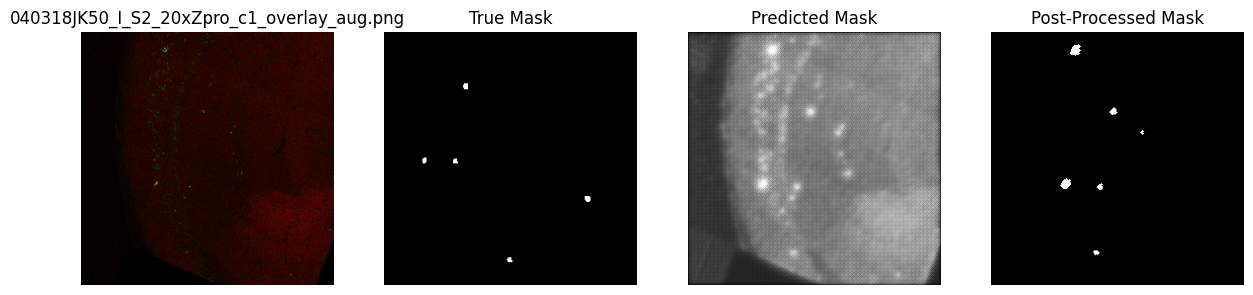

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


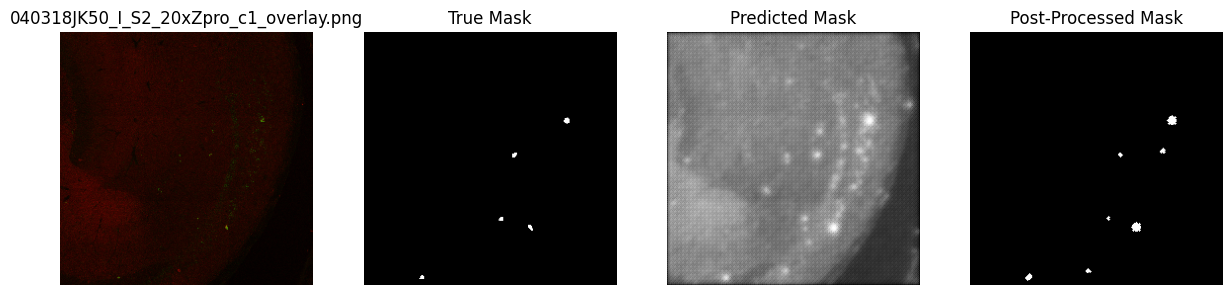

In [35]:
def apply_morphological_operations(pred_mask, threshold=0.9, min_area=10, max_area=100, min_circularity=0.4):
    binary_mask = (pred_mask > threshold).astype(np.uint8)
    
    selem = disk(1)
    
    opened_mask = opening(binary_mask, selem)
    closed_mask = closing(opened_mask, selem)

    label_img = label(closed_mask)
    regions = regionprops(label_img)
    
    filtered_mask = np.zeros_like(closed_mask)

    for region in regions:
        if min_area <= region.area <= max_area:
            circularity = (4 * np.pi * region.area) / (region.perimeter * region.perimeter)
            if circularity >= min_circularity:
                for coordinates in region.coords:                
                    filtered_mask[coordinates[0], coordinates[1]] = 1
                
    return filtered_mask

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if len(image.shape) == 3 and image.shape[2] == 3:
        channels = cv2.split(image)
        clahe_applied = [clahe.apply(channel) for channel in channels]
        clahe_image = cv2.merge(clahe_applied)
    else:
        clahe_image = clahe.apply(image)
    return clahe_image

def plot_true_vs_predicted_with_post_processing(test_images, test_masks, model, filenames):
    for i in range(len(test_images)):
        image = test_images[i]
        true_mask = test_masks[i].squeeze()
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()
        
        clahe_pred_mask = apply_clahe((pred_mask * 255).astype(np.uint8)) 
        post_processed_mask = apply_morphological_operations(clahe_pred_mask / 255)

        plt.figure(figsize=(15, 10))
        
        plt.subplot(1, 4, 1)
        plt.imshow(image)
        plt.title(f'{filenames[i]}')
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(post_processed_mask, cmap='gray')
        plt.title('Post-Processed Mask')
        plt.axis('off')
        
        plt.show()

plot_true_vs_predicted_with_post_processing(test_images[:5], test_masks[:5], model, test_filenames[:5])

## Step 7: Visualize the protein markers from the predictions on test 

The bounding boxes are meant to identify and locate the overlapping proteins. Then, plotting applies the aforementioned preprocessing to the mask and extracts the bounding boxes from the predicted masks, 
T the original test images are displayed alongside tse images with the calculated bounding boxes superimposed on themH highliginght thpredicted instances of overlapping proteins from the predicted mask,neach instance of these bounding boxes are added up to report the number of overlapping proteins detected in the image.s.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


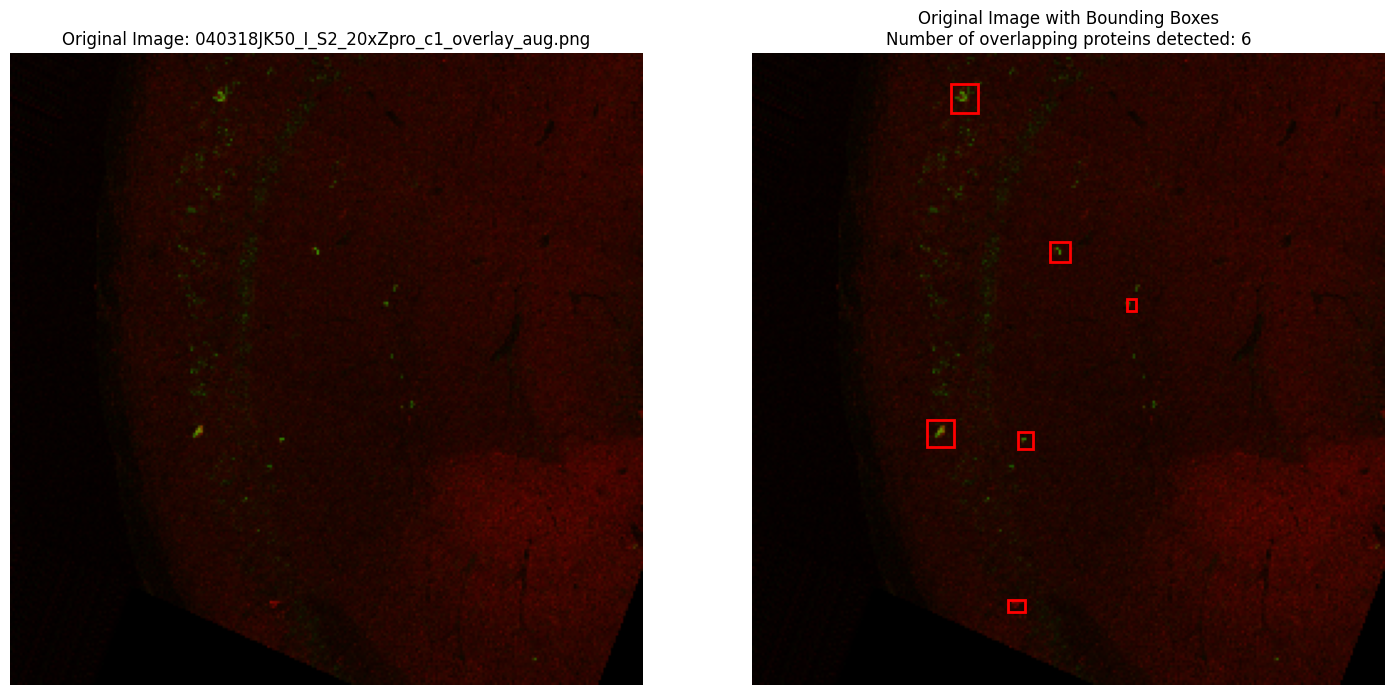

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


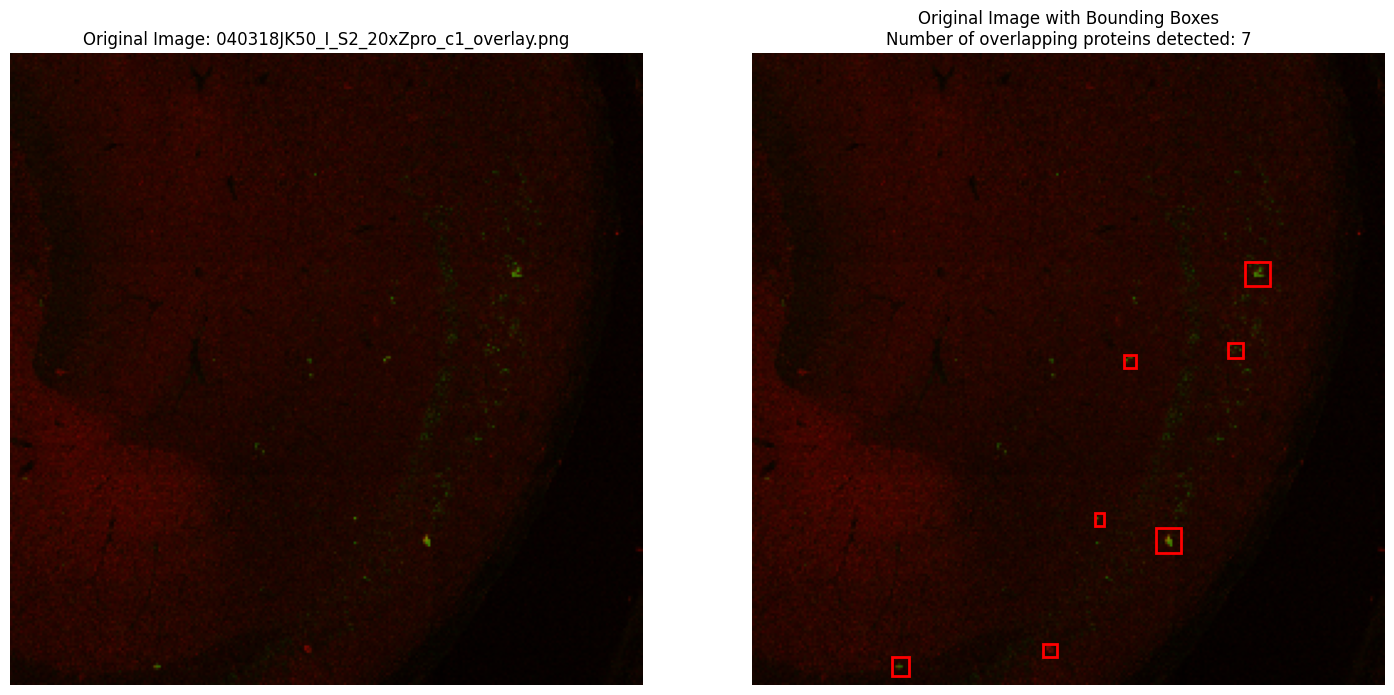

In [36]:
def calculate_bounding_boxes(mask):
    label_img = label(mask)
    regions = regionprops(label_img)
    boxes = []
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        boxes.append((minc, minr, maxc, maxr))
    return boxes

def plot_images_with_boxes_and_count(test_images, model, filenames):
    for i in range(len(test_images)):
        image = test_images[i]
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()

        clahe_pred_mask = apply_clahe((pred_mask * 255).astype(np.uint8))
        post_processed_mask = apply_morphological_operations(clahe_pred_mask / 255)

        bounding_boxes = calculate_bounding_boxes(post_processed_mask)
        num_boxes = len(bounding_boxes)
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        ax[0].imshow(image)
        ax[0].set_title(f'Original Image: {filenames[i]}')
        ax[0].axis('off')

        ax[1].imshow(image)
        for bbox in bounding_boxes:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax[1].add_patch(rect)
        ax[1].set_title(f'Original Image with Bounding Boxes\nNumber of overlapping proteins detected: {num_boxes}')
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

plot_images_with_boxes_and_count(test_images[:5], model, test_filenames[:5])